In [2]:
import numpy as np
import polars as pl
import os, sys, math, re, time, random
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.mixture
import sklearn.cluster
import sklearn.manifold
import sklearn.preprocessing
import sklearn.decomposition

In [3]:
root = "/home/exyi/mount/random_blackbox/"
output_dir = root + "home/standa/contacts_clusters/out/"
contact_csv_dir = f"{root}home/jirka/contacts/contacts_gemmi_symmetry_polar_base"
# contact_csv_dir = f"{root}scratch/contacts/contacts_gemmi"
# good_file_list = [
#     root + "scratch/contacts/00_fr3d-python/all_IDs/golden_clean/cWW_U_A_upto1.8A.csv",
#     root + "scratch/contacts/00_fr3d-python/all_IDs/golden_clean/cWW_A_U_upto1.8A.csv",
#     root + "scratch/contacts/00_fr3d-python/all_IDs/golden_clean/cWW_U_A_upto1.8A.csv",
#     root + "scratch/contacts/00_fr3d-python/all_IDs/golden_clean/cWW_U_G_upto1.8A.csv",
# ]
# contact_csvs = pl.concat(
#     pl.scan_csv(file, has_header=False).select(pl.col("column_1")).unique()
#     for file in good_file_list
# ).unique().collect()["column_1"]


def read_lines(file):
    with open(file) as f:
        return [line.strip() for line in f.readlines()]
contact_csvs = np.array([
    # *read_lines(f"{root}home/jirka/contacts/scores/results_2.2A_DNA_ids"),
    # *read_lines(f"{root}home/jirka/contacts/scores/results_2.2A_RNA_ids"),
    *read_lines(f"{root}home/jirka/contacts/scores/results_1.8A_DNA_ids"),
    *read_lines(f"{root}home/jirka/contacts/scores/results_1.8A_RNA_ids"),
])
contact_csvs

array(['1a2e', '1bf4', '1c8c', '1da9', '1dc0', '1dc1', '1dnz', '1dpn',
       '1dp7', '1d23', '1d56', '1d61', '1d8g', '1d8x', '1egw', '1em0',
       '1ene', '1en8', '1fd5', '1fn1', '1gu4', '1ih6', '1ikk', '1i1p',
       '1i3w', '1jes', '1jpq', '1jux', '1jx4', '1j8l', '1ljx', '1l1t',
       '1l1z', '1mnn', '1m5r', '1m6r', '1m77', '1nr8', '1orn', '1pjo',
       '1puy', '1p4y', '1qyl', '1rh6', '1r2z', '1r3z', '1sxq', '1s23',
       '1tez', '1ub8', '1ue2', '1ue4', '1u1q', '1wtv', '1w0u', '1xa2',
       '1xjv', '1xjx', '1xux', '1xvr', '1zex', '1zfb', '1zf0', '1zf1',
       '1zf4', '1zf7', '1zf8', '1zf9', '1zs4', '1ztw', '1zzi', '118d',
       '138d', '145d', '159d', '196d', '2avh', '2a7e', '2bcq', '2bcr',
       '2bdp', '2b2b', '2dp6', '2etw', '2euw', '2eux', '2euz', '2evf',
       '2evg', '2evi', '2e42', '2fih', '2fii', '2fjx', '2fmp', '2f8w',
       '2gb7', '2gw0', '2hto', '2ibt', '2ih2', '2ih5', '2itl', '2nq9',
       '2oaa', '2obz', '2odi', '2o1i', '2o4a', '2pkv', '2p2r', '2q10',
      

In [4]:
contact_files = set(os.listdir(contact_csv_dir)).intersection(c + ".csv" for c in contact_csvs)
contact_files_fn = [f"{contact_csv_dir}/{file}" for file in contact_files]
contact_files_fn = [ f for f in contact_files_fn if os.stat(f).st_size > 0 ]
schema = pl.read_csv(f"{contact_csv_dir}/1ehz.csv").schema
def load_df(p1, p2):
    schema_casts = [ pl.col(c).cast(t) for c, t in schema.items()]
    all_contacts = pl.concat(pl.scan_csv(file).with_columns(*schema_casts) for file in contact_files_fn)
    reasonable_contacts = (
        all_contacts
            # .filter((pl.col("res1") == "U") & (pl.col("res2") == "A"))
            # .filter((pl.col("res1") == p1) & (pl.col("res2") == p2))
            .filter(pl.col("tripletx").eq("x") & pl.col("triplety").eq("y") & pl.col("tripletz").eq("z") & pl.col("pdbsymstr").eq("1_555"))
    )
    df = reasonable_contacts.collect()
    print(df.shape)
    matrix = df[["tx", "ty", "tz", "r11", "r12", "r13", "r21", "r22", "r23", "r31", "r32", "r33"]].to_numpy().astype(np.float32)
    return df, matrix

df, matrix = load_df("G", "C")

(91568, 45)


In [5]:
print(np.mean(matrix, axis=0))
print(np.std(matrix, axis=0))
def normalize_matrix(matrix):
    matrix_normalized = (matrix - np.mean(matrix, axis=0)) / np.std(matrix, axis=0)
    matrix_quantile_normalized = np.argsort(matrix, axis=0) / matrix.shape[0]
    print(matrix.shape, matrix_normalized.shape, matrix_quantile_normalized.shape)
    matrix_normal_refit = scipy.stats.norm.ppf(matrix_quantile_normalized * 0.9998415 + 0.0001)
    return matrix_normalized, matrix_normal_refit
matrix_normalized, matrix_normal_refit = normalize_matrix(matrix)

[-2.6088643e+00  2.9208021e+00 -4.6558339e-02  4.7250187e-01
  3.4077436e-01  5.4801017e-02  3.4077159e-01  1.9245847e-01
  2.9156238e-02  5.4761391e-02  2.9210487e-02 -7.2290760e-04]
[4.423261   4.833276   7.631748   0.48019126 0.614958   0.22103097
 0.61496145 0.64990675 0.21313843 0.22103529 0.2131367  0.94966495]
(91568, 12) (91568, 12) (91568, 12)


In [6]:
# tsne_transform = sklearn.manifold.TSNE(n_components=2)
tsne_transform = sklearn.decomposition.PCA(n_components=2,whiten=True)
tsne_normalized = tsne_transform.fit_transform(matrix_normalized)
# tsne_plain = sklearn.manifold.TSNE(n_components=2).fit_transform(matrix)
# tsne_4dim = sklearn.manifold.TSNE(n_components=3).fit_transform(matrix_normalized)
tsne_4dim = sklearn.decomposition.PCA(n_components=3, whiten=True).fit_transform(matrix_normalized)

[32 37 39 ... 39 36 30]


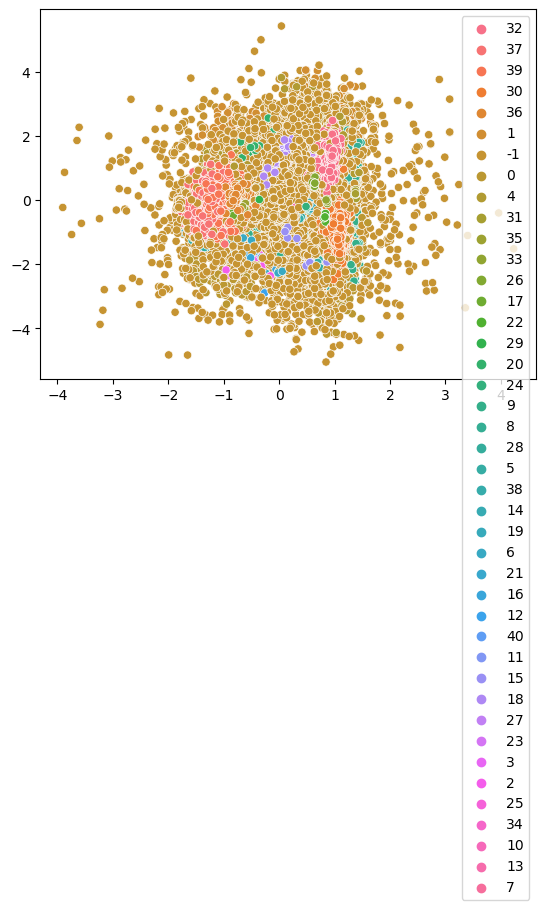

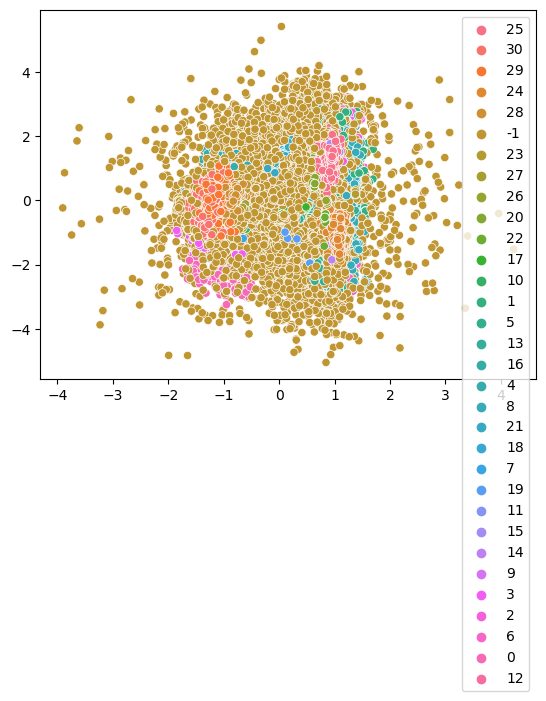

NameError: name 'clusters3' is not defined

In [7]:
# clusterrer = sklearn.mixture.BayesianGaussianMixture(n_components=10, covariance_type="full", max_iter=1000, verbose=1, init_params="k-means++")
# clusterrer = sklearn.mixture.GaussianMixture(n_components=10, covariance_type="full", max_iter=1000, verbose=1)
# clusterrer = sklearn.cluster.HDBSCAN(min_cluster_size=50, cluster_selection_epsilon=0.05, metric="infinity")
clusterrer = sklearn.cluster.HDBSCAN(min_cluster_size=35, cluster_selection_epsilon=0.000)
# clusterrer = sklearn.cluster.DBSCAN(eps=3, min_samples=20)
clusters = clusterrer.fit_predict(matrix)
clusters2 = clusterrer.fit_predict(matrix_normalized)
# clusters3 = clusterrer.fit_predict(tsne_4dim)
print(clusters)
sns.scatterplot(x=tsne_normalized[:, 0], y=tsne_normalized[:, 1], hue=clusters.astype(str))
plt.show()
sns.scatterplot(x=tsne_normalized[:, 0], y=tsne_normalized[:, 1], hue=clusters2.astype(str))
plt.show()
# sns.scatterplot(x=tsne_normalized[:, 0], y=tsne_normalized[:, 1], hue=clusters3.astype(str))
# plt.show()

In [8]:
def filter_all_matrices(clusters):
    filter_bitmap = clusters2 >= 0
    matrix_f = matrix[filter_bitmap]
    matrix_f_normalized = (matrix_f - np.mean(matrix_f, axis=0)) / np.std(matrix_f, axis=0)
    df_f = df.filter(filter_bitmap)
    tsne_4dim_f = tsne_4dim[filter_bitmap]
    tsne_normalized_f = tsne_normalized[filter_bitmap]
    return df_f, matrix_f, matrix_f_normalized, tsne_4dim_f, tsne_normalized_f
df_f, matrix_f, matrix_f_normalized, tsne_4dim_f, tsne_normalized_f = filter_all_matrices(clusters2)
pl.Series("cluster_id", clusters2).value_counts().sort(pl.col("cluster_id"))

cluster_id,counts
i64,u32
-1,18905
0,66
1,310
2,41
3,180
4,222
5,307
6,35
7,61


Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
  Iteration 310
  Iteration 320
  Iteration 330
  Iteration 340
Initialization converged: True
[ 2 24 22 ... 35 14  0]


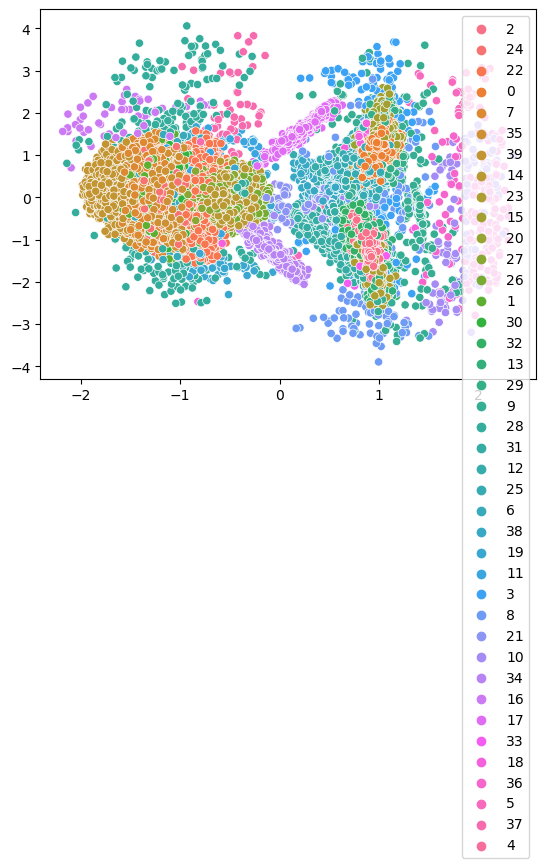

In [10]:
clusterrer2 = sklearn.mixture.BayesianGaussianMixture(n_components=40, covariance_type="full", max_iter=1000, verbose=1, init_params="k-means++")
# clusterrer2 = sklearn.mixture.GaussianMixture(n_components=10, covariance_type="full", max_iter=1000, verbose=1)
clusters_f1 = clusterrer2.fit_predict(matrix_f)
print(clusters_f1)
new_tsne = tsne_transform.fit_transform(matrix_f_normalized)
sns.scatterplot(x=new_tsne[:, 0], y=new_tsne[:, 1], hue=clusters_f1.astype(str))
plt.show()
# sns.scatterplot(x=tsne_normalized_f[:, 0], y=tsne_normalized_f[:, 1], hue=clusters_f1.astype(str))
# plt.show()
# sns.scatterplot(x=tsne_normalized_f[:, 0], y=tsne_normalized_f[:, 1], hue=clusters_f1.astype(str))
# plt.show()

In [17]:
def save_clusters(clusters, d, data = df, min_size = 10):
    print(d)
    os.makedirs(d, exist_ok=True)
    for c in np.sort(np.unique(clusters)):
        bitmap = clusters == c
        if np.sum(bitmap) < min_size:
            print(f"Skipping cluster {c} with {np.sum(bitmap)} entries")
        subdf = data.filter(bitmap)
        print(f"Writing cluster {c} with {np.sum(bitmap)} entries")
        subdf.write_csv(d + "/" + f"cluster_{c}.csv")

# save_clusters(clusters_f1, f"./out_clusters_all_HDB+GMM_n20", data=df_f)
save_clusters(clusters2, output_dir + f"./out_clusters_all_HDB_n30", data=df)
save_clusters(clusters_f1, output_dir + f"./out_clusters_all_HDB+GMM_n40", data=df_f)
# save_clusters(clusters3, f"./out_clusters_tsne")
print(df.shape, df_f.shape)

/home/exyi/mount/random_blackbox/home/standa/contacts_clusters/out/./out_clusters_all_HDB_n30
Writing cluster -1 with 18905 entries
Writing cluster 0 with 66 entries
Writing cluster 1 with 310 entries
Writing cluster 2 with 41 entries
Writing cluster 3 with 180 entries
Writing cluster 4 with 222 entries
Writing cluster 5 with 307 entries
Writing cluster 6 with 35 entries
Writing cluster 7 with 61 entries
Writing cluster 8 with 357 entries
Writing cluster 9 with 40 entries
Writing cluster 10 with 196 entries
Writing cluster 11 with 116 entries
Writing cluster 12 with 46 entries
Writing cluster 13 with 117 entries
Writing cluster 14 with 70 entries
Writing cluster 15 with 66 entries
Writing cluster 16 with 39 entries
Writing cluster 17 with 477 entries
Writing cluster 18 with 61 entries
Writing cluster 19 with 540 entries
Writing cluster 20 with 373 entries
Writing cluster 21 with 542 entries
Writing cluster 22 with 383 entries
Writing cluster 23 with 156 entries
Writing cluster 24 with 

In [37]:
# generate clusters for all pair combinations
for pairs in [ ["GC"], ["CG"], ["AT", "AU"], ["TA", "UA"], ["CT", "CU"], ["GT", "GU"], ["CA"], ["GA"], ["CC"], ["GG"], ["TT", "UU", "TU", "UT"], ["AA"] ]:
    x = [ load_df(p[0], p[1]) for p in pairs ]
    df_all = pl.concat([ d[0] for d in x ])
    matrix_all = np.concatenate([ d[1] for d in x ])
    mnorm, mrefit = normalize_matrix(matrix_all)
    clusters = clusterrer.fit_predict(mnorm)
    save_clusters(clusters, d + f"out_clusters_{pairs[0]}_HDB", data=df_all)
    # filter_bitmap = clusters >= 0
    # matrix_f = matrix_all[filter_bitmap]
    # df_f = df_all.filter(filter_bitmap)
    # clusters2 = clusterrer2.fit_predict(matrix_f)

(16286, 45)
(16286, 12) (16286, 12) (16286, 12)
Writing cluster -1 with 3891 entries
Writing cluster 0 with 219 entries
Writing cluster 1 with 39 entries
Writing cluster 2 with 2213 entries
Writing cluster 3 with 1963 entries
Writing cluster 4 with 37 entries
Writing cluster 5 with 99 entries
Writing cluster 6 with 6087 entries
Writing cluster 7 with 1738 entries
(16286, 45)
(16286, 12) (16286, 12) (16286, 12)
Writing cluster -1 with 3950 entries
Writing cluster 0 with 37 entries
Writing cluster 1 with 120 entries
Writing cluster 2 with 2211 entries
Writing cluster 3 with 35 entries
Writing cluster 4 with 1950 entries
Writing cluster 5 with 96 entries
Writing cluster 6 with 6114 entries
Writing cluster 7 with 1773 entries
(0, 45)
(9391, 45)
(9391, 12) (9391, 12) (9391, 12)
Writing cluster -1 with 4081 entries
Writing cluster 0 with 49 entries
Writing cluster 1 with 192 entries
Writing cluster 2 with 910 entries
Writing cluster 3 with 831 entries
Writing cluster 4 with 58 entries
Writin